In [2]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import json
import pickle
import tensorflow as tf
import tensorflow_addons as tfa
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Input, concatenate
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.models import model_from_json, load_model, Model
import plotly.express as px

2025-04-07 03:24:57.290319: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-07 03:24:57.686262: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-07 03:24:57.794234: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/taras/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/cv2/.

In [3]:
# 1️⃣ Load and Preprocess Data
# Constants to define
IMG_SIZE = (256, 256)
X_SIZE = IMG_SIZE[0]
Y_SIZE = IMG_SIZE[1]
TRAIN_DATASET_PATH = "../dataset/train/"
TRAIN_IMAGES_PATH = os.path.join(TRAIN_DATASET_PATH, "images")
TRAIN_MASKS_PATH = os.path.join(TRAIN_DATASET_PATH, "targets")  # Segmentation masks
TRAIN_LABELS_PATH = os.path.join(TRAIN_DATASET_PATH, "labels")  # JSON labels

TEST_DATASET_PATH = "../dataset/test/"
TEST_IMAGES_PATH = os.path.join(TEST_DATASET_PATH, "images")
TEST_MASKS_PATH = os.path.join(TEST_DATASET_PATH, "targets")  # Segmentation masks
TEST_LABELS_PATH = os.path.join(TEST_DATASET_PATH, "labels")  # JSON labels

BATCH_SIZE = 16  # Number of images to treat at once (Adjust depending on your RAM)
BUFFER_SIZE = 2799  # Total number of images to load from dataset

N_AUG = 701 # Number of augmented images to generate

In [4]:
# Function to load and preprocess images and masks
def load_image(image_path,verbose=0):
    """Load and preprocess images."""
    img = cv2.imread(image_path)

    if verbose==0:  # LOad messages
        pass
    elif verbose == 1:
        if img is None:
            print(f"❌ Failed to load image: {image_path}")
            return None
        print(f"✅ Loaded image {image_path}, Shape: {img.shape}, Dtype: {img.dtype}")

    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE) / 255.0  # Normalize
    return img

def load_mask(mask_path,num_classes=5,verbose=0):
    """Load and preprocess masks."""
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    if verbose==0:  # LOad messages
        pass
    elif verbose == 1:
        if mask is None:
            print(f"❌ Failed to load mask: {mask_path}")
            return None
        print(f"✅ Loaded mask {mask_path}, Shape: {mask.shape}, Dtype: {mask.dtype}")

    mask = cv2.resize(mask, IMG_SIZE, interpolation=cv2.INTER_NEAREST)
    mask = tf.keras.utils.to_categorical(mask, num_classes=num_classes)
    mask.astype(np.float32)
    return mask


In [5]:
# # Find images with at least X unique pixel values
# def find_images_with_min_unique_values(folder_path, min_unique_values=3):
#     """Finds images in a folder with at least `min_unique_values` unique pixel values."""
    
#     image_files = [f for f in os.listdir(folder_path) if f.endswith(('.png', '.jpg', '.jpeg'))]
#     valid_images = []

#     for file in image_files:
#         print(f"Checking {file}...")
#         img_path = os.path.join(folder_path, file)
#         mask = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load as grayscale
        
#         if mask is None:
#             print(f"❌ Could not load {file}")
#             continue
        
#         unique_values = np.unique(mask)  # Get unique pixel values
        
#         if len(unique_values) >= min_unique_values:
#             valid_images.append(file)  # Store filenames that meet the condition

#     return valid_images

# # Example usage
# folder = "../dataset/train/targets"
# matching_images = find_images_with_min_unique_values(folder, min_unique_values=5)

# print("Images with at least 3 unique pixel values:")
# matching_images

(256, 256, 5)


(-0.5, 255.5, 255.5, -0.5)

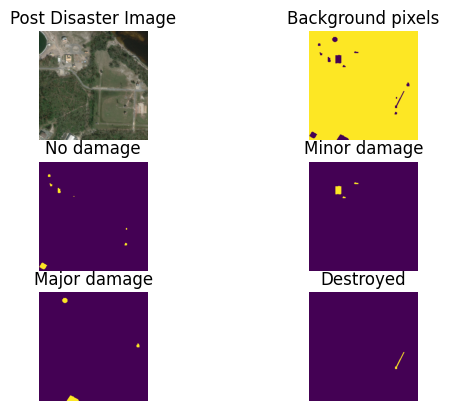

In [6]:
# Load and visualize a sample image and mask (mask is a 5-channel image with one-hot encoding)
a = load_mask(TRAIN_MASKS_PATH+"/hurricane-michael_00000486_post_disaster_target.png")
b = load_image(TRAIN_IMAGES_PATH+"/hurricane-michael_00000486_post_disaster.png")
print(a.shape)
plt.subplot(321)
plt.title("Post Disaster Image")
plt.imshow(b)
plt.axis('off')
plt.subplot(322)
plt.title("Background pixels")
plt.imshow(a[:,:,0])
plt.axis('off')
plt.subplot(323)
plt.title("No damage")
plt.imshow(a[:,:,1])
plt.axis('off')
plt.subplot(324)
plt.title("Minor damage")
plt.imshow(a[:,:,2])
plt.axis('off')
plt.subplot(325)
plt.title("Major damage")
plt.imshow(a[:,:,3])
plt.axis('off')
plt.subplot(326)
plt.title("Destroyed")
plt.imshow(a[:,:,4])
plt.axis('off')



In [7]:
# Function to load dataset using tf.data
def dataset_generator(image_filenames, images_path, masks_path):
    """Generator function to yield images and masks."""
    for filename in image_filenames:
        pre_path = os.path.join(images_path, filename)
        post_path = os.path.join(images_path, filename.replace("_pre_disaster", "_post_disaster"))
        mask_path = os.path.join(masks_path, filename.replace("_pre_disaster.png", "_post_disaster_target.png"))

        pre_img = load_image(pre_path)
        post_img = load_image(post_path)
        mask_img = load_mask(mask_path) # Now returns (256, 256, 5)
        

        if pre_img is not None and post_img is not None and mask_img is not None:
            stacked_image = np.concatenate([pre_img, post_img], axis=-1)  # Shape: (256, 256, 6)
            yield stacked_image, mask_img

# Create TensorFlow dataset
def get_tf_dataset(image_filenames, images_path, masks_path, batch_size, num_additional_samples=0):
    # Create original dataset
    dataset = tf.data.Dataset.from_generator(
        lambda: dataset_generator(image_filenames, images_path, masks_path),
        output_signature=(
            tf.TensorSpec(shape=(X_SIZE, Y_SIZE, 6), dtype=tf.float32),
            tf.TensorSpec(shape=(X_SIZE, Y_SIZE, 5), dtype=tf.float32)  # One-hot encoded mask
        )
    )
    
    dataset = dataset.take(BUFFER_SIZE)  # Limit number of samples
    dataset = dataset.shuffle(BUFFER_SIZE)  # Shuffle the data
    dataset = dataset.batch(batch_size)  # Load in small batches
    dataset = dataset.prefetch(tf.data.AUTOTUNE)  # Optimize loading

    # Apply augmentations
    augmented_dataset = dataset.map(augment, num_parallel_calls=tf.data.experimental.AUTOTUNE)

    # Concatenate original and augmented datasets in the TensorFlow pipeline
    combined_dataset = dataset.concatenate(augmented_dataset)  # Concatenate the original and augmented datasets

    return combined_dataset


In [8]:
#Adding some augmentations to the data

# Define the augmentation function
def augment(X, Y):
    # Random scaling
    scale_factor = tf.random.uniform([], 0.5, 1.5)
    new_size = tf.cast(tf.cast(tf.shape(X)[:2], tf.float32) * scale_factor, tf.int32)
    X = tf.image.resize(X, new_size)
    Y = tf.image.resize(Y, new_size)

    # Random rotation
    angle = tf.random.uniform([], -15.0, 15.0) * (3.14159265 / 180.0)  # Convert degrees to radians
    X = tfa.image.rotate(X, angle)
    Y = tfa.image.rotate(Y, angle)

    # Random brightness
    X = tf.image.random_brightness(X, 0.3)

    # Random contrast
    X = tf.image.random_contrast(X, 0.7, 1.3)

    # Resize back to original shape
    X = tf.image.resize(X, (X_SIZE, Y_SIZE))
    Y = tf.image.resize(Y, (X_SIZE, Y_SIZE))

    return X, Y



In [9]:
# Create a list of the images and masks to load (here we use only the _pre_disaster images and then when needed we rename the list to _post_disaster)
train_image_filenames = sorted([
    f for f in os.listdir(TRAIN_IMAGES_PATH) 
    if "_pre_disaster.png" in f and not f.startswith(".") and ":Zone.Identifier" not in f # Exclude Windows Zone Identifier files
])

test_image_filenames = sorted([
    f for f in os.listdir(TEST_IMAGES_PATH) 
    if "_pre_disaster.png" in f and not f.startswith(".") and ":Zone.Identifier" not in f
])

# Get datasets
train_dataset = get_tf_dataset(
    train_image_filenames,
    TRAIN_IMAGES_PATH,
    TRAIN_MASKS_PATH,
    BATCH_SIZE,
    N_AUG)

test_dataset = get_tf_dataset(
    test_image_filenames,
    TEST_IMAGES_PATH,
    TEST_MASKS_PATH,
    BATCH_SIZE,
    10)

2025-04-07 03:25:02.007847: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/taras/.pyenv/versions/3.10.12/envs/Artefact/lib/python3.10/site-packages/cv2/../../lib64:
2025-04-07 03:25:02.008528: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2025-04-07 03:25:02.008557: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (Taramas): /proc/driver/nvidia/version does not exist
2025-04-07 03:25:02.011536: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with t

In [10]:

# 2️⃣ Define U-Net Model
def unet_model(input_shape=(X_SIZE, Y_SIZE, 6), num_classes=5):
    inputs = Input(input_shape)

    # Encoder
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, (3,3), activation='relu', padding='same')(c1)
    p1 = MaxPooling2D((2,2))(c1)

    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(p1)
    c2 = Conv2D(128, (3,3), activation='relu', padding='same')(c2)
    p2 = MaxPooling2D((2,2))(c2)

    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(p2)
    c3 = Conv2D(256, (3,3), activation='relu', padding='same')(c3)
    p3 = MaxPooling2D((2,2))(c3)

    # Bottleneck
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(p3)
    c4 = Conv2D(512, (3,3), activation='relu', padding='same')(c4)

    # Decoder
    u5 = Conv2DTranspose(256, (2,2), strides=(2,2), padding='same')(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(u5)
    c5 = Conv2D(256, (3,3), activation='relu', padding='same')(c5)

    u6 = Conv2DTranspose(128, (2,2), strides=(2,2), padding='same')(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(u6)
    c6 = Conv2D(128, (3,3), activation='relu', padding='same')(c6)

    u7 = Conv2DTranspose(64, (2,2), strides=(2,2), padding='same')(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(u7)
    c7 = Conv2D(64, (3,3), activation='relu', padding='same')(c7)

    outputs = Conv2D(num_classes, (1,1), activation='softmax')(c7)  # Multiclass segmentation output
    model = Model(inputs, outputs)
    return model



In [11]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name="f1_score", **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.precision_metric = tf.keras.metrics.Precision()
        self.recall_metric = tf.keras.metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision_metric.update_state(y_true, y_pred)
        self.recall_metric.update_state(y_true, y_pred)

    def result(self):
        precision = self.precision_metric.result()
        recall = self.recall_metric.result()
        return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

    def reset_states(self):
        self.precision_metric.reset_states()
        self.recall_metric.reset_states()

In [12]:
# Compile and Train Model

MODEL_NAME = "unet_v10_multiclass"
NUMBER_OF_EPOCHS = 1



model = unet_model() 
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics= ['accuracy', F1Score()])

class SaveTrainingLogs(tf.keras.callbacks.Callback):
    def __init__(self, log_filename="../models/"+f"{MODEL_NAME}_training_log.txt"):
        self.log_filename = log_filename

    def on_epoch_end(self, epoch, logs=None):
        with open(self.log_filename, "a") as f:
            f.write(f"Epoch {epoch+1}: {logs}\n")

# Train the model with the callback
os.makedirs("../models/", exist_ok=True)  # Create if it doesn't exist
log_callback = SaveTrainingLogs()
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join("../models/", f"{MODEL_NAME}_epoch_{{epoch:02d}}.h5"),  # Save each epoch
    save_best_only=False,  # Save model at every epoch
    save_weights_only=False,  # Save full model
    verbose=1
)

model.fit(
    train_dataset,          # Training dataset (from tf.data)
    validation_data=test_dataset,  # Validation dataset
    epochs=NUMBER_OF_EPOCHS,               # Number of training cycles
    shuffle = True,
    callbacks=[log_callback,checkpoint_callback]
)

# # Convert model to JSON (architecture)
# model_json = model.to_json()

# # Save the JSON + Weights using pickle
# with open("models/unet_v8_multiclass_epoch_20.pkl", "wb") as f:
#     pickle.dump({"architecture": model_json, "weights": model.get_weights()}, f)




2025-04-07 03:25:18.285426: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 250 of 2799
2025-04-07 03:25:28.278145: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 489 of 2799
2025-04-07 03:25:38.282847: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 726 of 2799
2025-04-07 03:25:48.280859: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 976 of 2799
2025-04-07 03:25:58.287112: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1193 of 2799
2025-04-07 03:26:08.275352: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle buffer (this may take a while): 1428 of 2799
2025-04-07 03:26:18.274079: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:390] Filling up shuffle

: 

In [17]:
# Load the model
model = unet_model() 
model.load_weights("../models/unet_v10_multiclass_epoch_10.h5")

# # Verify model architecture
# model.summary()

In [14]:
imno = 4
for test_image, test_mask in test_dataset.take(1):
    test_images = test_image
    test_masks = test_mask
b1 = test_images[imno, :, :, :3]  # Take the first image
b2 = test_images[imno, :, :, 3:]  # Take the second image
a = model.predict(test_images[:, :, :, :])  # Predict on the first image
a = a[imno, :, :, :]  # Take the first channel (background)
c = test_masks[imno, :, :, :]  # Take the first mask (grayscale)


1/1 [==============================] - 1s 766ms/step


Number of 1s per channel: [5.15997e+05 7.97900e+03 0.00000e+00 3.12000e+02 0.00000e+00]
1/1 [==============================] - 1s 649ms/step
Number of 1s per channel: [227896.31  114771.195  68252.016  50963.977  62362.58 ]


[]

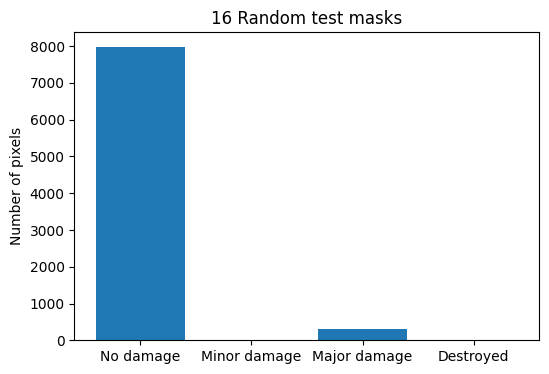

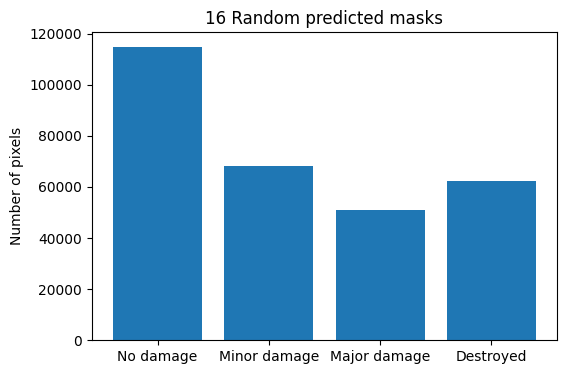

In [15]:
counts_per_channel = np.sum(test_masks, axis=(0, 1, 2))  # Sum over all images and pixels
print("Number of 1s per channel:", counts_per_channel)
plt.figure(figsize=(6,4))
plt.bar([1,2,3,4],counts_per_channel[1:])  # For values 0–4
plt.xticks([1,2,3,4], ["No damage", "Minor damage", "Major damage", "Destroyed"])
plt.ylabel("Number of pixels")
plt.title("16 Random test masks")
plt.plot()

counts_per_channel = np.sum(model.predict(test_images), axis=(0, 1, 2))  # Sum over all images and pixels
print("Number of 1s per channel:", counts_per_channel)
plt.figure(figsize=(6,4))
plt.bar([1,2,3,4],counts_per_channel[1:])  # For values 0–4
plt.xticks([1,2,3,4], ["No damage", "Minor damage", "Major damage", "Destroyed"])
plt.ylabel("Number of pixels")
plt.title("16 Random predicted masks")
plt.plot()


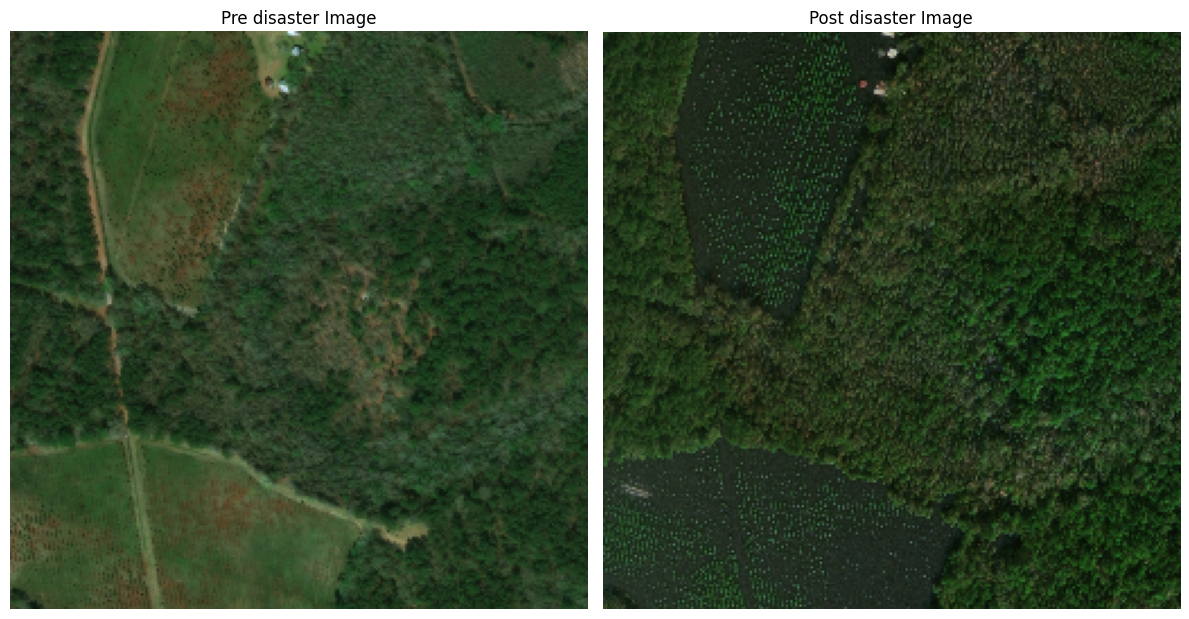

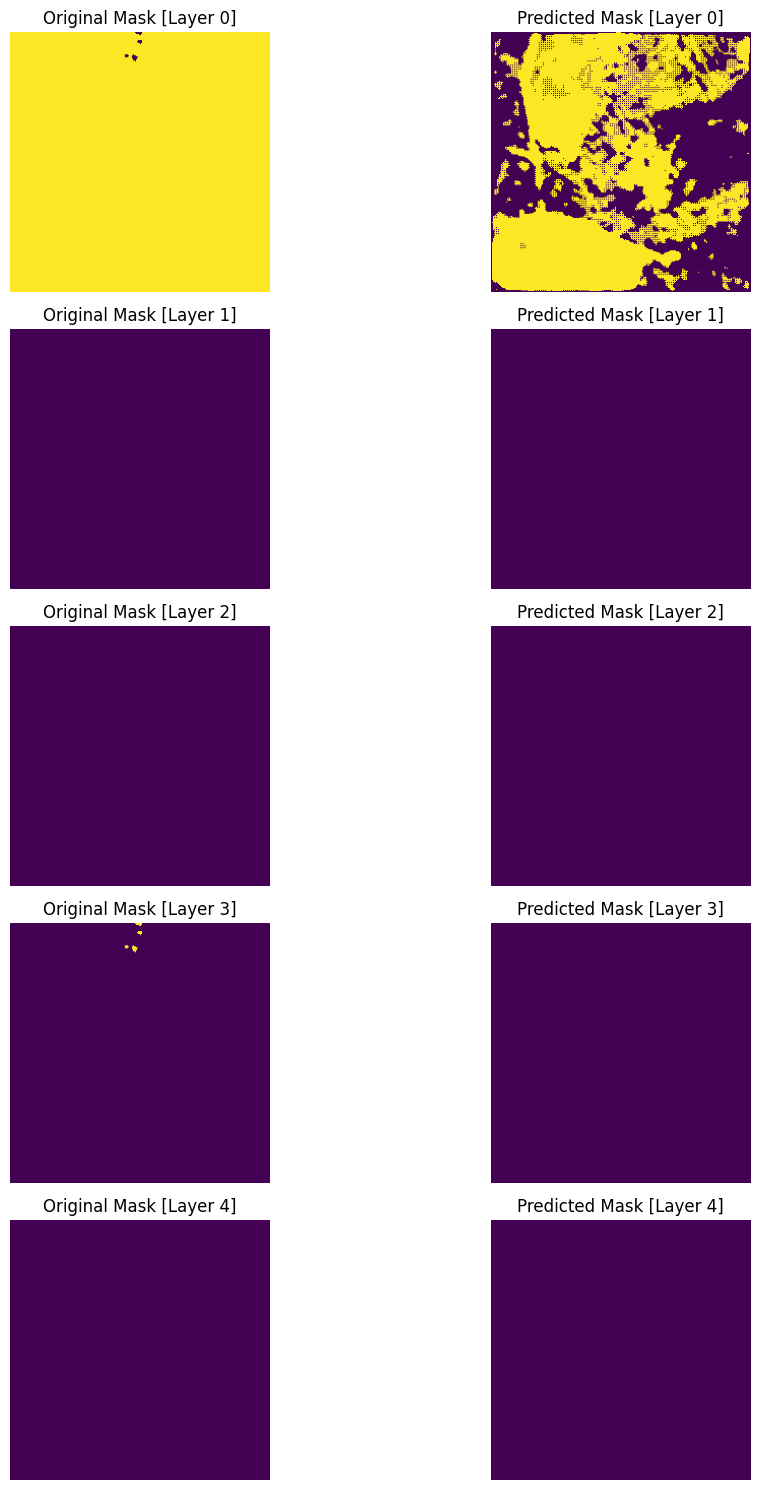

In [16]:

plt.figure(figsize=(12, 15))  # Width x Height in inches

plt.subplot(121)
plt.title("Pre disaster Image")
plt.imshow(b1)  # Take the first image)
plt.axis('off')

plt.subplot(122)
plt.title("Post disaster Image")
plt.imshow(b2)  # Take the first image)
plt.axis('off')
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


plt.figure(figsize=(12, 15))

# Original vs Predicted per channel
for i in range(5):
    plt.subplot(5, 2, 2*i + 1)
    plt.title(f"Original Mask [Layer {i}]")
    plt.imshow(c[:, :, i])
    plt.axis('off')

    plt.subplot(5, 2, 2*i + 2)
    plt.title(f"Predicted Mask [Layer {i}]")
    plt.imshow(a[:, :, i]>0.4, vmin=0, vmax=1)
    plt.axis('off')

plt.tight_layout()
plt.show()

(256, 256, 5)
(256, 256, 3)


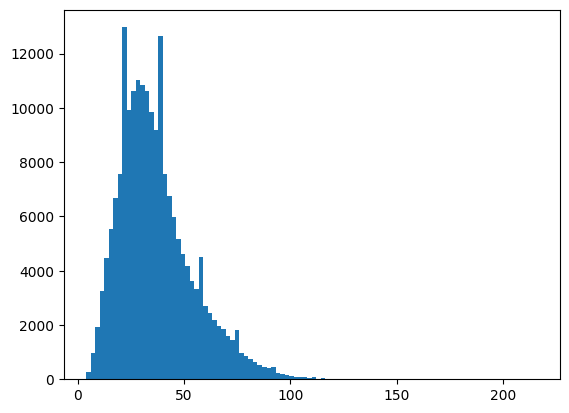

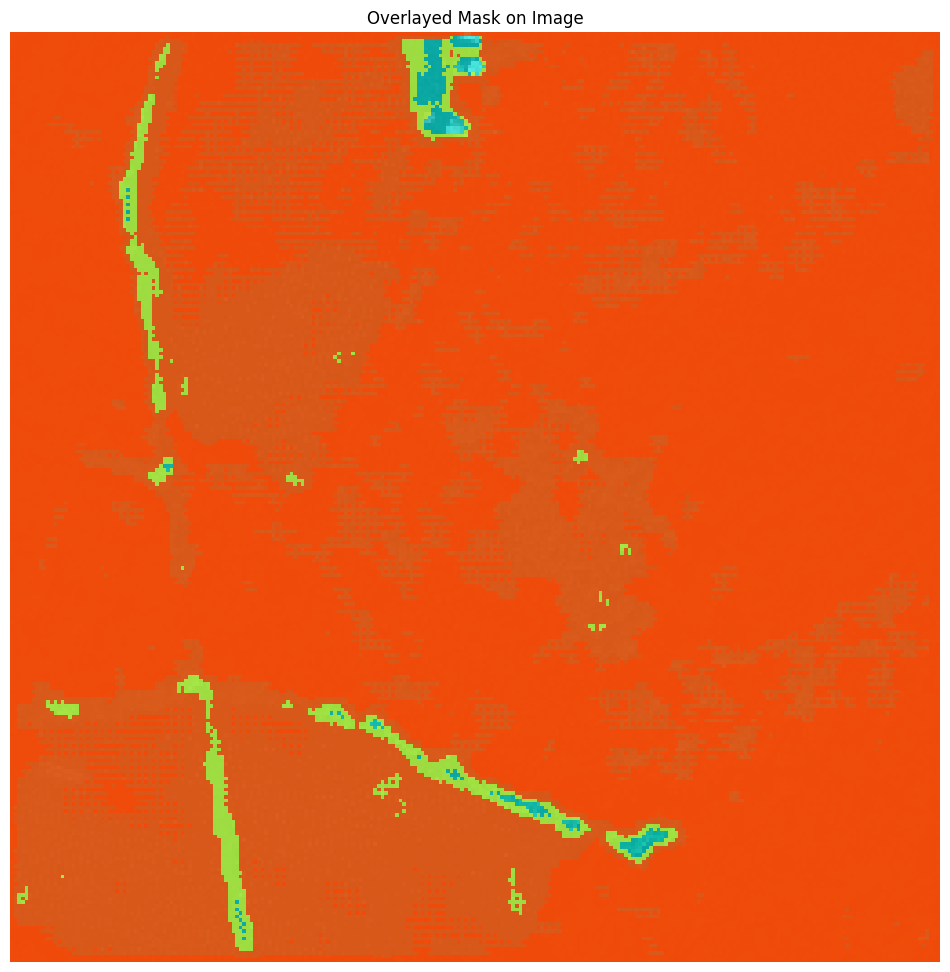

In [17]:
import numpy as np
import cv2

def overlay_masks_on_image(image, mask, alpha=0.4):
    """
    Overlays a color image with a 5-channel mask.
    
    Parameters:
        image (np.ndarray): RGB image of shape (X, Y, 3), dtype=uint8.
        mask (np.ndarray): One-hot encoded mask of shape (X, Y, 5), dtype=uint8 or bool.
        alpha (float): Transparency of the mask overlay.
        
    Returns:
        np.ndarray: Image of shape (X, Y, 3) with mask overlay.
    """
    # Define RGBA colors for each layer (skip layer 0: transparent)

    colors = {
        1: (0, 255, 255),    # Cyan
        2: (255, 255, 0),    # Yellow
        3: (255, 165, 0),    # Orange
        4: (255, 0, 0),      # Red
    }

    overlay = image.copy()

    for i in range(1, 5):  # Skip channel 0 (transparent)
        mask_layer = mask[:, :, i]
        color = np.array(colors[i], dtype=np.uint8)

        # Create a colored layer with the mask
        color_mask = np.zeros_like(image, dtype=np.uint8)
        for c in range(3):
            color_mask[:, :, c] = color[c] * mask_layer

        # Blend the color mask with the original image
        overlay = np.where(mask_layer[..., None], 
                           (1 - alpha) * overlay + alpha * color_mask,
                           overlay)

    return overlay.astype(np.uint8)

image = np.array(b2)*255
mask = np.array(a>0.1)
print(mask.shape)


plt.hist(image.flatten(), bins=100)

result = overlay_masks_on_image(image, mask, alpha=0.6)  # Overlay the mask on the image
print(result.shape)
plt.figure(figsize=(12, 15))
plt.imshow(result[:,:,:])
plt.axis('off')
plt.title("Overlayed Mask on Image")
plt.show()

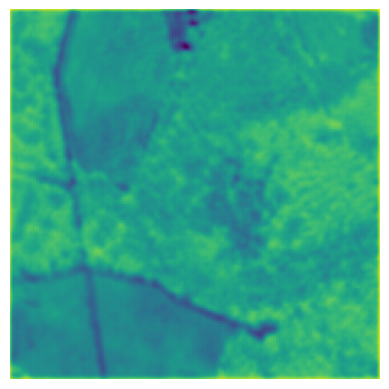

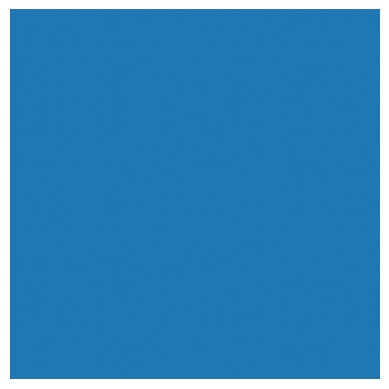

(256, 256, 5)
(256, 256)


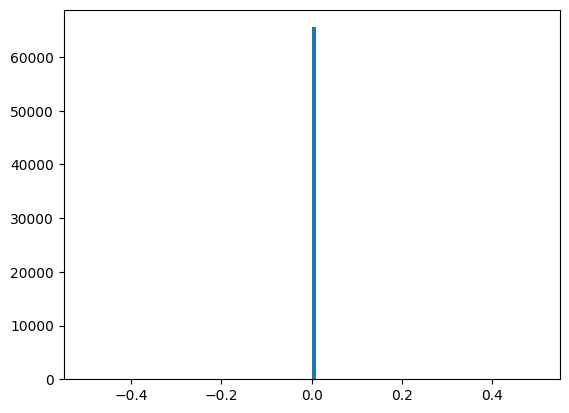

In [18]:
a.shape
plt.imshow(a[:,:,4])
plt.axis('off')
plt.show()
aa = tf.argmax(a, axis=-1)  # Ground truth labels

plt.imshow(aa, cmap='tab10')
plt.axis('off')
plt.show()
print(a.shape)
print(aa.shape)
plt.hist(np.array(aa).flatten(), bins=100)
plt.show(   )

In [ ]:
fig = px.imshow(train_masks[2, :, :, 1], color_continuous_scale='jet')

fig.update_traces(
    hovertemplate='Pixel Value: %{z}<extra></extra>' ) # Customize the hover text



In [33]:
prediction = model.predict(train_masks[2, :, :,:])  # Predict the output for the image

fig = px.imshow(prediction[2,:,:,1], color_continuous_scale='jet')

# Enable hover data to show pixel values
fig.update_traces(
    hovertemplate='Pixel Value: %{z}<extra></extra>' ) # Customize the hover text


: 